In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as FFF
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [59]:
# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [60]:
# Параметры двигателя
R_s = 1.405
L_ls = 0.005839
L_m = 0.1722
L_s = L_ls + L_m

R_r_prime = 1.395
L_lr_prime = 0.005839
L_r_prime = L_lr_prime + L_m

J = 0.0131
F = 0.002985
p = 2
S = 4000
w0 = 2*np.pi*50
H = (J * w0**2)/(2 * S)

In [61]:
# Загрузка данных
df = pd.read_csv('output.csv')
df

,time,idr,iqr,wm,vds,vqs,ids,iqs,phids,phiqs,phidr,phiqr,te,thetam,vdr,vqr
0,0.000000e+00,0.000000e+00,0.000000e+00,157.079633,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0
1,3.155444e-30,0.000000e+00,0.000000e+00,157.079633,-3.166766e+02,182.833330,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.956559e-28,0,0
2,5.421011e-20,1.445801e-15,-8.343529e-16,157.079633,-3.166766e+02,182.833330,-1.494825e-15,8.626443e-16,-1.717033e-17,9.908761e-18,-1.182063e-23,-5.588521e-24,-5.382740e-38,8.515303e-18,0,0
3,5.421011e-20,1.445801e-15,-8.343529e-16,157.079633,-3.166766e+02,182.833330,-1.494825e-15,8.626443e-16,-1.717033e-17,9.908761e-18,-1.182063e-23,-5.588521e-24,-5.382740e-38,8.515303e-18,0,0
4,5.421011e-20,1.445801e-15,-8.343529e-16,157.079633,6.229020e-15,365.666659,-1.494825e-15,8.626443e-16,-1.717033e-17,9.908761e-18,-1.182063e-23,-5.588521e-24,-5.382740e-38,8.515303e-18,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17622,4.996016e-01,-1.051863e+01,-1.260207e+00,147.322647,-1.256663e-02,0.002950,1.256663e+01,-2.950492e+00,4.260427e-01,-7.423104e-01,2.912479e-01,-7.324408e-01,2.421392e+01,7.298848e+01,0,0
17623,4.996016e-01,-1.051863e+01,-1.260207e+00,147.322647,-1.256663e-02,0.002950,1.256663e+01,-2.950492e+00,4.260427e-01,-7.423104e-01,2.912479e-01,-7.324408e-01,2.421392e+01,7.298848e+01,0,0
17624,4.996016e-01,-1.051863e+01,-1.260207e+00,147.322647,1.479210e+02,334.409551,1.256663e+01,-2.950492e+00,4.260427e-01,-7.423104e-01,2.912479e-01,-7.324408e-01,2.421392e+01,7.298848e+01,0,0
17625,4.997032e-01,-9.712039e+00,-3.035719e+00,147.306461,1.578628e+02,329.830987,1.174101e+01,-1.113006e+00,4.179447e-01,-7.209093e-01,2.926804e-01,-7.321360e-01,2.399709e+01,7.300344e+01,0,0


In [62]:
# Входные данные
t_data = df['time'].values
v_ds_data = df['vds'].values
v_qs_data = df['vqs'].values

# Моделируемые данные
i_dr_data = df['idr'].values
i_ds_data = df['ids'].values
i_qr_data = df['iqr'].values
i_qs_data = df['iqs'].values
phi_dr_data = df['phidr'].values
phi_ds_data = df['phids'].values
phi_qr_data = df['phiqr'].values
phi_qs_data = df['phiqs'].values
te_data = df['te'].values
thetam_data = df['thetam'].values
v_dr_data = df['vdr'].values
v_qr_data = df['vqr'].values
w_m_data = df['wm'].values

tm_data = 1.1853e-3 * w_m_data ** 2

In [63]:
# Прореживание данных с шагом 300
step = 1
half_len = len(t_data) // 2
t_train = t_data[:half_len:step]
v_ds_train = v_ds_data[:half_len:step]
v_qs_train = v_qs_data[:half_len:step]

i_dr_train = i_dr_data[:half_len:step]
i_ds_train = i_ds_data[:half_len:step]
i_qr_train = i_qr_data[:half_len:step]
i_qs_train = i_qs_data[:half_len:step]
phi_dr_train = phi_dr_data[:half_len:step]
phi_ds_train = phi_ds_data[:half_len:step]
phi_qr_train = phi_qr_data[:half_len:step]
phi_qs_train = phi_qs_data[:half_len:step]
te_train = te_data[:half_len:step]
w_m_train = w_m_data[:half_len:step]

tm_train = 1.1853e-3 * w_m_train ** 2

# Преобразуем в тензоры
t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1).to(device)
v_ds_tensor = torch.tensor(v_ds_train, dtype=torch.float32).view(-1, 1).to(device)
v_qs_tensor = torch.tensor(v_qs_train, dtype=torch.float32).view(-1, 1).to(device)

i_dr_tensor = torch.tensor(i_dr_train, dtype=torch.float32).to(device)
i_ds_tensor = torch.tensor(i_ds_train, dtype=torch.float32).to(device)
i_qr_tensor = torch.tensor(i_qr_train, dtype=torch.float32).to(device)
i_qs_tensor = torch.tensor(i_qs_train, dtype=torch.float32).to(device)
phi_dr_tensor = torch.tensor(phi_dr_train, dtype=torch.float32).to(device)
phi_ds_tensor = torch.tensor(phi_ds_train, dtype=torch.float32).to(device)
phi_qr_tensor = torch.tensor(phi_qr_train, dtype=torch.float32).to(device)
phi_qs_tensor = torch.tensor(phi_qs_train, dtype=torch.float32).to(device)
te_tensor = torch.tensor(te_train, dtype=torch.float32).to(device)
w_m_tensor = torch.tensor(w_m_train, dtype=torch.float32).to(device)

tm_tensor = torch.tensor(tm_train, dtype=torch.float32).view(-1, 1).to(device)

In [64]:
# Вторая часть — только для физических ограничений
step = 5
t_physics = t_data[::step]
i_dr_physics = i_dr_data[::step]
i_ds_physics = i_ds_data[::step]
i_qr_physics = i_qr_data[::step]
i_qs_physics = i_qs_data[::step]
phi_dr_physics = phi_dr_data[::step]
phi_ds_physics = phi_ds_data[::step]
phi_qr_physics = phi_qr_data[::step]
phi_qs_physics = phi_qs_data[::step]
v_dr_physics = v_dr_data[::step]
v_ds_physics = v_ds_data[::step]
v_qr_physics = v_qr_data[::step]
v_qs_physics = v_qs_data[::step]
te_physics = te_data[::step]
w_m_physics = w_m_data[::step]

tm_physics = 1.1853e-3 * w_m_physics ** 2

# Преобразуем в тензоры
t_physics_tensor = torch.tensor(t_physics, dtype=torch.float32).view(-1, 1).to(device)
v_ds_physics_tensor = torch.tensor(v_ds_physics, dtype=torch.float32).view(-1, 1).to(device)
v_qs_physics_tensor = torch.tensor(v_qs_physics, dtype=torch.float32).view(-1, 1).to(device)


i_dr_physics_tensor = torch.tensor(i_dr_physics, dtype=torch.float32).to(device)
i_ds_physics_tensor = torch.tensor(i_ds_physics, dtype=torch.float32).to(device)
i_qr_physics_tensor = torch.tensor(i_qr_physics, dtype=torch.float32).to(device)
i_qs_physics_tensor = torch.tensor(i_qs_physics, dtype=torch.float32).to(device)
phi_dr_physics_tensor = torch.tensor(phi_dr_physics, dtype=torch.float32).to(device)
phi_ds_physics_tensor = torch.tensor(phi_ds_physics, dtype=torch.float32).to(device)
phi_qr_physics_tensor = torch.tensor(phi_qr_physics, dtype=torch.float32).to(device)
phi_qs_physics_tensor = torch.tensor(phi_qs_physics, dtype=torch.float32).to(device)
v_dr_physics_tensor = torch.tensor(v_dr_physics, dtype=torch.float32).to(device)
v_qr_physics_tensor = torch.tensor(v_qr_physics, dtype=torch.float32).to(device)
te_physics_tensor = torch.tensor(te_physics, dtype=torch.float32).to(device)
w_m_physics_tensor = torch.tensor(w_m_physics, dtype=torch.float32).to(device)

tm_physics_tensor = torch.tensor(tm_physics, dtype=torch.float32).view(-1, 1).to(device)

In [65]:
class MultiOutputNN(nn.Module):
    def __init__(self, input_size=4, hidden_sizes=[256]*200, output_size=6, dropout_prob=0):
        super(MultiOutputNN, self).__init__()
        
        # Общие слои (shared layers)
        self.shared_fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.shared_fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.shared_fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        
        # Batch Normalization
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.bn3 = nn.BatchNorm1d(hidden_sizes[2])
        
        # Dropout
        self.dropout = nn.Dropout(dropout_prob)
        
        # Выходные слои (10 нейронов)
        self.output_layer = nn.Linear(hidden_sizes[2], output_size)
        
    def forward(self, x):
        # Общая часть (shared backbone)
        x = FFF.leaky_relu(self.bn1(self.shared_fc1(x)), negative_slope=0.01)
        x = self.dropout(x)
        
        x = FFF.silu(self.bn2(self.shared_fc2(x)))  # Swish (SiLU)
        x = self.dropout(x)
        
        x = FFF.gelu(self.bn3(self.shared_fc3(x)))  # GELU
        
        # Выход (10 значений)
        x = self.output_layer(x)
        return x

In [66]:
def physics_loss(model, physics_data):
    t, v_ds, v_qs, tm = physics_data
    t.requires_grad_(True)
    pred = model(torch.cat([t, v_ds, v_qs, tm], dim=1))
    

    i_dr, i_ds, i_qr, i_qs = pred[:, 0], pred[:, 1], pred[:, 2], pred[:, 3]
    t_e = pred[:, 4]
    w_m = pred[:, 5]

    # Производные
    dwm_dt = torch.autograd.grad(w_m, t, grad_outputs=torch.ones_like(w_m), create_graph=True)[0]

    # Потокосцепления
    phi_dr = L_r_prime * i_dr + L_m * i_qr
    phi_ds = L_s * i_ds + L_m * i_dr
    phi_qr = L_r_prime * i_qr + L_m * i_qs
    phi_qs = L_s * i_qs + L_m * i_dr

    omega = w0
    omega_r = p * w_m

    # Уравнения статора и ротора
    v_qs_pred = R_s * i_qs + torch.autograd.grad(phi_qs, t, grad_outputs=torch.ones_like(phi_qs), create_graph=True)[0] + omega * phi_ds
    v_ds_pred = R_s * i_ds + torch.autograd.grad(phi_ds, t, grad_outputs=torch.ones_like(phi_ds), create_graph=True)[0] - omega * phi_qs
    v_qr_pred = R_r_prime * i_qr + torch.autograd.grad(phi_qr, t, grad_outputs=torch.ones_like(phi_qr), create_graph=True)[0] + (omega - omega_r) * phi_dr
    v_dr_pred = R_r_prime * i_dr + torch.autograd.grad(phi_dr, t, grad_outputs=torch.ones_like(phi_dr), create_graph=True)[0] - (omega - omega_r) * phi_qr
    eq_stator_q = (v_qs - v_qs_pred) * v_qs_pred
    eq_stator_d = (v_ds - v_ds_pred) * v_ds_pred
    eq_rotor_q = (0 - v_qr_pred) * v_qr_pred
    eq_rotor_d = (0 - v_dr_pred) * v_dr_pred

    eq_omega = dwm_dt - (1/(2*H)) * (t_e - F * w_m - tm)

    return torch.mean(eq_stator_q ** 2 + eq_stator_d ** 2 + eq_rotor_q ** 2 + eq_rotor_d ** 2 + eq_omega ** 2)

In [67]:
# Функция потерь
def loss_function(model, data, physics_data):
    t_data, v_ds_data, v_qs_data, tm_data = data
    pred = model(torch.cat([t_data, v_ds_data, v_qs_data, tm_data], dim=1))
    
    i_dr, i_ds, i_qr, i_qs = pred[:, 0], pred[:, 1], pred[:, 2], pred[:, 3]
    t_e = pred[:, 4]
    w_m = pred[:, 5]
    
    # Loss on data
    loss_i_dr = torch.mean((i_dr - i_dr_tensor) ** 2)
    loss_i_ds = torch.mean((i_ds - i_ds_tensor) ** 2)
    loss_i_qr = torch.mean((i_qr - i_qr_tensor) ** 2)
    loss_i_qs = torch.mean((i_qs - i_qs_tensor) ** 2)
    loss_t_e = torch.mean((t_e - te_tensor) ** 2)
    loss_w_m  = torch.mean((w_m - w_m_tensor) ** 2)

    loss_data = (
        loss_i_dr + loss_i_ds + loss_i_qr + loss_i_qs + 
        loss_t_e + loss_w_m
    )

    loss_physics = physics_loss(model, physics_data)
    
    total_loss = loss_data + 0.5*loss_physics
    return total_loss

In [68]:
# Установите нужное значение seed
seed = 101
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [69]:
model = MultiOutputNN(input_size=4, hidden_sizes=[512]*12, output_size=6).to(device)

# Оптимизатор и планировщик
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=50)

epochs = 35_000
print_every = 50  # интервал вывода
# Обучение с tqdm
model.train()
with tqdm(total=epochs, desc="Training Epochs", ncols=100, colour='green') as pbar:
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_function(model, (t_tensor, v_ds_tensor, v_qs_tensor, tm_tensor), (t_physics_tensor, v_ds_physics_tensor, v_qs_physics_tensor, tm_physics_tensor))
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        # Обновляем прогресс-бар
        if (epoch + 1) % print_every == 0:
            pbar.set_postfix_str(f"Loss: {loss.item():.6f}")
        pbar.update(1)

Training Epochs:   2%|▍                   | 868/35000 [04:19<2:50:22,  3.34it/s, Loss: 22353.542969]


KeyboardInterrupt: 

C:\Users\ventus\AppData\Local\Temp\ipykernel_6292\620576035.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


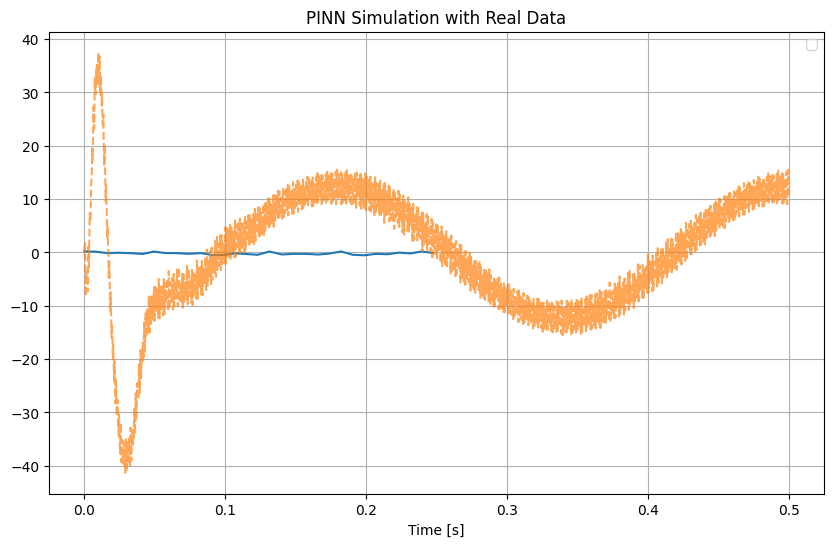

In [ ]:
# Графики
# # i_dr', i_ds, i_qr', i_qs, wm - предсказания
model.eval()
with torch.no_grad():
    pred = model(torch.cat([t_tensor, v_ds_tensor, v_qs_tensor, tm_tensor], dim=1))
    predicted_w_m = pred[:, 1].cpu().numpy()
    plt.figure(figsize=(10, 6))
    plt.plot(t_tensor.cpu().numpy(), predicted_w_m)
    plt.plot(t_data, i_ds_data, '--', alpha=0.7)
    plt.xlabel('Time [s]')
    plt.title('PINN Simulation with Real Data')
    plt.grid(True)
    plt.legend()
    plt.show()